In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import time
from datetime import datetime
import torch
import torch.nn as nn
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytesseract
from io import StringIO
from model import TableNet

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [3]:
TRANSFORM = A.Compose([
                #ToTensor --> Normalize(mean, std)
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                    max_pixel_value = 255,
                ),
                ToTensorV2()
    ])

In [4]:
model = TableNet(encoder = 'densenet', use_pretrained_model = True, basemodel_requires_grad = True)
model.eval()

#load checkpoint
model.load_state_dict(torch.load("densenet_config_4_model_checkpoint.pth.tar")['state_dict'])

<All keys matched successfully>

In [7]:
def predict(img_path):
    orig_image = Image.open(img_path).resize((1024, 1024))
    test_img = np.array(orig_image.convert('LA').convert("RGB"))

    now = datetime.now()
    image = TRANSFORM(image = test_img)["image"]
    with torch.no_grad():
        image = image.unsqueeze(0)
        #with torch.cuda.amp.autocast():
        table_out, _  = model(image)
        table_out = torch.sigmoid(table_out)

    #remove gradients
    table_out = (table_out.detach().numpy().squeeze(0).transpose(1,2,0) > 0.5).astype(np.uint8)

    #get contours of the mask to get number of tables
    contours, table_heirarchy = cv2.findContours(table_out, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    table_contours = []
    #ref: https://www.pyimagesearch.com/2015/02/09/removing-contours-image-using-python-opencv/
    #remove bad contours
    for c in contours:

        if cv2.contourArea(c) > 3000:
            table_contours.append(c)

    if len(table_contours) == 0:
        print("No Table detected")

    table_boundRect = [None]*len(table_contours)
    for i, c in enumerate(table_contours):
        polygon = cv2.approxPolyDP(c, 3, True)
        table_boundRect[i] = cv2.boundingRect(polygon)

    #table bounding Box
    table_boundRect.sort()

    orig_image = np.array(orig_image)
    #draw bounding boxes
    color = (0,0,255)
    thickness = 4

    for x,y,w,h in table_boundRect:
        cv2.rectangle(orig_image, (x,y),(x+w,y+h), color, thickness)
    
    plt.figure(figsize = (20,10))
    plt.imshow(orig_image)
    plt.show()
    
    end_time = datetime.now()
    difference = end_time - now
    #print("Total Time : {} seconds".format(difference))
    time = "{}".format(difference)

    print(f"Time Taken on cpu : {time} secs")

    print("Predicted Tables")

    image = test_img[...,0].reshape(1024, 1024).astype(np.uint8)

    for i,(x,y,w,h) in enumerate(table_boundRect):
        image_crop = image[y:y+h,x:x+w]
        data = pytesseract.image_to_string(image_crop)
        try:
            df = pd.read_csv(StringIO(data),sep=r'\|',lineterminator=r'\n',engine='python')
            print(f" ## Table {i+1}")
            df = pd.read_csv(StringIO(data),sep=r'\|',lineterminator=r'\n',engine='python')
            print(df)
        except pd.errors.ParserError:
            try:
                df = pd.read_csv(StringIO(data),delim_whitespace=True,lineterminator=r'\n',engine='python')
                print(f" ## Table {i+1}")
                print(df)
            except pd.errors.ParserError:
                print(f" ## Table {i+1}")
                print(df)

    

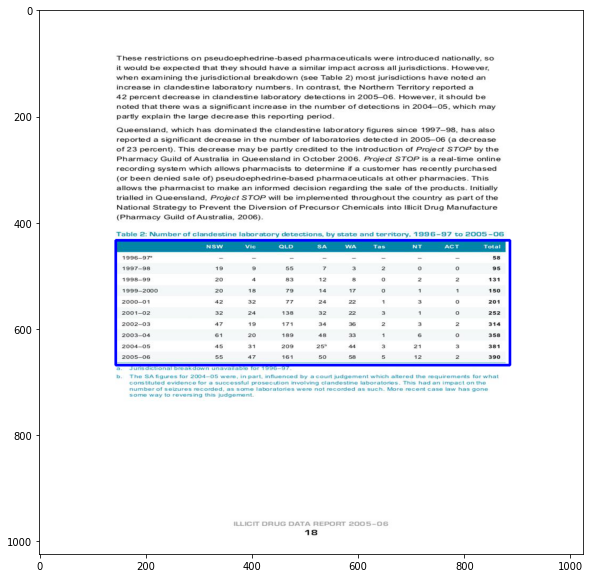

Time Taken on cpu : 0:00:29.167146 secs
Predicted Tables
 ## Table 1
   Nsw Vie Lo SA WA Tas NT act Total
0        1996-97" = = = = = = = — Pa
1       1997-98 19 9 95 7 3 2 ° ° 95
2     1998-99 20 4 83 12 8 ° 2 2 434
3  1999-2000 20 18 79 4 v7 ° 1 1 150
4     2000-01 42 32 7 24 2 1 3 ° 201
5   2001-02 32 2a 138 32 2 3 1 ° 252
6   2002-03 a7 19 71 34 26 2 3 2 214
7   2003-04 6 20 189 48 23 1 6 ° 358
8     2004-05 45 a 209 25 a 21 3 381
9   2005-06 55 a7 161 50 58 12 2 390


In [8]:
predict(img_path = '../marmot_processed/image/10.1.1.180.553_10.jpg')